In [ ]:
import torch
from lag_llama.gluon.estimator import LagLlamaEstimator
from lag_llama.gluon.lightning_module import LagLlamaLightningModule
from gluonts.torch.distributions.studentT import StudentTOutput
import torch.serialization
from gluonts.torch.modules.loss import NegativeLogLikelihood
torch.serialization.add_safe_globals([StudentTOutput, NegativeLogLikelihood])

# Permitir cargar la clase StudentTOutput en torch.load (PyTorch >=2.6)
torch.serialization.add_safe_globals([StudentTOutput])

# 1. Cargar el checkpoint
ckpt = torch.load("checkpoints/lag-llama.ckpt", map_location="cpu", weights_only=False)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

# 2. Completar los argumentos requeridos (si no están)
estimator_args.update({
    "prediction_length": 365,
    "context_length": 365,
    "distr_output": "studentT",
    "input_size": 1,
    "lags_seq": ["M"],
    "batch_size": 32,
    "num_batches_per_epoch": 10,
    "trainer_kwargs": {"max_epochs": 1},
})

# 3. Inicializar el estimator
estimator = LagLlamaEstimator(**estimator_args)

# 4. Crear el módulo desde el checkpoint
module = LagLlamaLightningModule.load_from_checkpoint(
    checkpoint_path="checkpoints/lag-llama.ckpt",
    map_location="cpu"
)

# 5. Crear transformación y predictor
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation=transformation, module=module)

/Users/sebastianulloa/.virtualenvs/py310/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1409: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


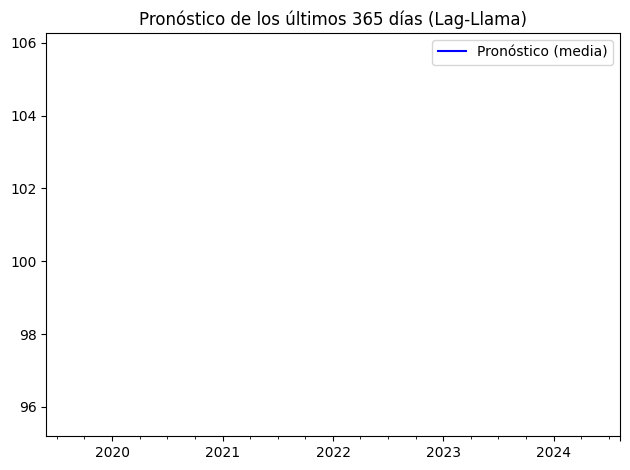

In [17]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

from lag_llama.gluon.estimator import LagLlamaEstimator
from lag_llama.gluon.lightning_module import LagLlamaLightningModule

from gluonts.dataset.pandas import PandasDataset
from gluonts.evaluation import make_evaluation_predictions
from gluonts.torch.distributions.studentT import StudentTOutput
from gluonts.torch.modules.loss import NegativeLogLikelihood
import torch.serialization

# Agregar clases necesarias a PyTorch 2.6+
torch.serialization.add_safe_globals([StudentTOutput, NegativeLogLikelihood])

# Cargar el checkpoint
ckpt_path = "checkpoints/lag-llama.ckpt"
ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

# Completar argumentos requeridos
estimator_args.update({
    "prediction_length": 365,
    "context_length": 180,
    "distr_output": "studentT",
    "input_size": 1,
    "lags_seq": ["D"],
    "batch_size": 32,
    "num_batches_per_epoch": 10,
    "trainer_kwargs": {"max_epochs": 1},
})

# Inicializar estimator
estimator = LagLlamaEstimator(**estimator_args)

# Crear módulo desde checkpoint
module = LagLlamaLightningModule.load_from_checkpoint(
    checkpoint_path=ckpt_path,
    map_location="cpu"
)

# Crear transformación y predictor
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation=transformation, module=module)

# Cargar datos
df = pd.read_csv("serie_3_anos.csv")

df["fecha"] = pd.to_datetime(df["fecha"])
df = df.set_index("fecha")

# 👇 Conversión de tipo
df["valor"] = df["valor"].astype("float32")

df = df[["valor"]]

# Crear dataset GluonTS
dataset = PandasDataset(df, target="valor", freq="D")
# Realizar predicciones
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset,
    predictor=predictor,
    num_samples=100
)
# Visualizar resultado
forecast = list(forecast_it)[0]
serie_real = list(ts_it)[0]

# Plot real
#serie_real.plot(label="Serie real", color="black")

# Plot predicción media
forecast.mean_ts.plot(label="Pronóstico (media)", color="blue")

# Opcional: intervalo de confianza
#forecast.quantile_ts(0.1).plot(label="P10", linestyle="--", color="skyblue")
#forecast.quantile_ts(0.9).plot(label="P90", linestyle="--", color="skyblue")

plt.legend()
plt.title("Pronóstico de los últimos 365 días (Lag-Llama)")
plt.tight_layout()
plt.show()

In [18]:
forecast_df = forecast.mean_ts.to_frame(name="mean")
print(forecast_df.head())

                  mean
2022-01-01  100.733955
